# Credit Card Customer Churn Prediction EDA

## Overview

Banks marketing teams invest a large amount of money for acquiring new credit card customers by launching lots of campaigns and offers, so it's crucial to retain existing customers.

Effective predictive ML models enables the business to pro-actively identify the risk of customer churn and provide any required offers to prevent customer churn.

## Approach

In order to achieve objective, I will follow below **CRISP-DM** framework steps. 

As part of this EDA notebook, will cover steps from 1 to 4 and remaining steps will be covered in [modeling notebook](creditcard-customer-churn-prediction-modeling-v5.ipynb)

1. **Business Understanding :** Define and understand the business problem 
2. **Data Understanding :** Understand the credit card input dataset and derive statistical inferences
3. **Data Preparation :** 
    - Perform required high level data cleaning techniques
4. **Exploratory Data Analysis(EDA) :** Perform the EDA on credit card dataset
    - Categorical feature distributions
    - Numerical feature distributions
    - Feature vs Target variable relationships
    - Correlation Analysis
    - Finalizing the Feature list
5. **Prediction Modeling :**
    - *Feature Engineering* :
        - Pre processing
        - Encoding
          - Robust Scalar Encoding
          - Onehot Encoding (For nominal categorical type features)
          - Ordinal Encoding (For ordinal categorical type features)
        - Splitting into training and testing sets
    - *Predictive Modeling*
        - Model selection approach
        - Model evaluation measures
        - Model Evaluation criteria
        - Training linear and tree based models (like Decision Tree/Gradient Boosting/Random Forest/LGBM)
        - Training with cross validation
6. **Model Performance Evaluation :**
    - Evaluate the performances of linear and tree based classification model scores and finalize the best model
7. **Hyperparameter Tuning :**
    - Tuning by using RandomizedSearchCV
    - Tuning by using Bayesian Optimization
8. **Results :**
    - Individual feature impact on finalized LGBM model prediction
9. **Future Work :**
10. **Conclusion :**
    - Business sugessions

## 1. Business Problem Statement

Identify the customers, who are likely to stop using credit card services
- Understand driving factors of churn
- Suggest strategic retention approaches to banks in order to prevent the churn


### 1.1 Objective

The goal of this project is to develop predictive machine learning model to predict credit card customer churn
- Identify the features which impact the customer churn 
- Build predictive model to accurately classify the likely hood of churn or continuity of service

**Expected Results**
- Analyze and identify patterns for churn driving factors
- Compare the various model performances and achieve highly effective predictor model for credit card customer churn
- The resulted model should serve the business to proactively identify and retain customers
- Translate insights into actionable business recommendations
 

### 1.2 Data Set

- **Source :** Kaggle's credit card customers dataset [Kaggle data source](https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers)
- **Description :** This dataset consists of 10,000 customers mentioning their age, salary, marital_status, credit card limit, credit card category, etc. There are nearly 18 features.
- **Rows :** 10K credit card customers data
- **Columns :** 23 features
- **Quality of Data :** We have only 16.07% of customers who have churned. Thus, it's a bit difficult to train our model to predict churning customers
- **Target/Dependent Variable :** Attrition_Flag (if the account is closed then 1 else 0)


## Libraries Used For This Analysis

In [8]:
# For this analysis, we are going to use below libraries
import pandas as pd
import numpy as np

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Filter warnings.
import warnings
warnings.filterwarnings('ignore')


## Common Functions Used for EDA and Pre Processing

In [11]:
# Functions to help with dataframe insights 
def null_values_per_column(df):
    '''
    List the null values count per column (This is useful to get raw na counts per column level)
    
    df: Input pandas dataframe
    
    returns
        the null values per column
    '''
    return df.isna().sum()


def null_values_pct_per_column(df):
    '''
    List % of null values count per column (This is useful understand over all na % per column)
    
    df: Input pandas dataframe
    
    returns
        the % of null values per column
    '''
    return (df.isna().sum() * 100)/len(df)

def get_cardinality_of_each_column(df):
    '''
    List the cardinality of each column 
    
    df: Input pandas dataframe
    
    returns
        disctionary of {column name} -> {it's corresponding distinct value count}
    '''
    column_cardinality_dict = {}
    for col in df.columns:
        column_cardinality_dict[col] = df[col].nunique()
    return column_cardinality_dict
        
    

def get_unique_feature_values(df, features):
    '''
    Gets the list of unique values per each given feature

    df: input pandas dataframe
    features: List of provided features
    
    returns: dictionary of feature vs it's unique values
    
    '''
    unique_feature_values = {}
    for feature in features:
        unique_feature_values[feature] = df[feature].unique()
    return unique_feature_values

# Data cleaning functions 
## filling with mode
def fill_missing_values_with_mode(df, features):
    '''
    Transoforms the input dataframe, by filling missing values of 
    each given feature column with their corresponding mode

    df: input pandas dataframe
    features: list of provided features

    returns: pandas dataframe by filling missing values with mode
    '''
    for feature in features:
        df[feature] = df[feature].fillna(df[feature].mode()[0])
    return df

def replace_with_first_n_digits(df, n, column_name):
    '''
    Replaces number column values with it's first n digits of column values

    df: input pandas dataframe
    column_name: numeric column name

    returns: dataframe with replaced column values
    '''
    df[column_name] = df[column_name].astype(int)
    df[column_name] = df[column_name].mod(n)
    return df

## 2. Understanding Data

### 2.1 Input Dataset Definitions

- **CLIENTNUM :** Client number. Unique identifier for the customer holding the account
- **Attrition_Flag :** Internal event (customer activity) variable - if the account is closed then 1 else 0
- **Customer_Age :** Demographic variable - Customer's Age in Years
- **Gender :** Demographic variable - M=Male, F=Female
- **Dependent_count :** Demographic variable - Number of dependents
- **Education_Level :** Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)
- **Marital_Status :** Demographic variable - Married, Single, Divorced, Unknown
- **Income_Category :** Demographic variable - Annual Income Category of the account holder (< $40K, $40K - 60K, $60K - $80K, $80K-$120K, > $120K, Unknown)
- **Card_Category :** Product Variable - Type of Card (Blue, Silver, Gold, Platinum)
- **Months_on_book :** Period of relationship with bank
- **Total_Relationship_Count :** Total number of products held by the customer
- **Months_Inactive_12_mon :** Number of months inactive in the last 12 months
- **Contacts_Count_12_mon :** Number of Contacts between the customer and bank in the last 12 months
- **Credit_Limit :** Credit Limit of the Credit Card
- **Total_Revolving_Bal :** The balance that carries over from one month to the next is the revolving balance
- **Avg_Open_To_Buy :** Open to Buy refers to the amount(avg in past 12 months) left on the credit card to use
- **Total_Amt_Chng_Q4_Q1 :** Ratio of the total transaction amount in 4th quarter and the total transaction amount in 1st quarter
- **Total_Trans_Amt :** Total Transaction Amount (Last 12 months)
- **Total_Trans_Ct :** Total Transaction Count (Last 12 months)
- **Total_Ct_Chng_Q4_Q1 :** Ratio of the total transaction count in 4th quarter and the total transaction count in 1st quarter
- **Avg_Utilization_Ratio :** Represents how much of the available credit the customer spent

[Reference](https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers/data) 

### 2.2 Structure of the Data and Summary

##### Reading the input raw data

In [17]:
# Read the data
creditcard_churners_data_path = '../data/BankChurners.csv'
credicard_raw_df = pd.read_csv(creditcard_churners_data_path)

# Size of the input data
print(f'size of the input raw data: {credicard_raw_df.shape}')
credicard_raw_df.columns.tolist()

size of the input raw data: (10127, 23)


['CLIENTNUM',
 'Attrition_Flag',
 'Customer_Age',
 'Gender',
 'Dependent_count',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']

##### Remove un necessary columns

In [20]:
unnecessary_features = ['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']

credicard_raw_df = credicard_raw_df.drop(columns=unnecessary_features, axis=1)

##### Let's look into data types and non null value counts per feature

In [23]:
credicard_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

##### Any duplicates?

In [26]:
credicard_raw_df.duplicated().sum()

0

##### Cardinality/unique values of each feature

In [29]:
get_cardinality_of_each_column(credicard_raw_df)

{'CLIENTNUM': 10127,
 'Attrition_Flag': 2,
 'Customer_Age': 45,
 'Gender': 2,
 'Dependent_count': 6,
 'Education_Level': 7,
 'Marital_Status': 4,
 'Income_Category': 6,
 'Card_Category': 4,
 'Months_on_book': 44,
 'Total_Relationship_Count': 6,
 'Months_Inactive_12_mon': 7,
 'Contacts_Count_12_mon': 7,
 'Credit_Limit': 6205,
 'Total_Revolving_Bal': 1974,
 'Avg_Open_To_Buy': 6813,
 'Total_Amt_Chng_Q4_Q1': 1158,
 'Total_Trans_Amt': 5033,
 'Total_Trans_Ct': 126,
 'Total_Ct_Chng_Q4_Q1': 830,
 'Avg_Utilization_Ratio': 964}

#### 2.3 Numerical Feature Statistics

In [32]:
# Let's look into numerical feature value distributions
pd.options.display.float_format = '{:.3f}'.format
credicard_raw_df.describe().T

,count,mean,std,min,25%,50%,75%,max
CLIENTNUM,10127.000,739177606.334,36903783.450,708082083.000,713036770.500,717926358.000,773143533.000,828343083.000
Customer_Age,10127.000,46.326,8.017,26.000,41.000,46.000,52.000,73.000
Dependent_count,10127.000,2.346,1.299,0.000,1.000,2.000,3.000,5.000
Months_on_book,10127.000,35.928,7.986,13.000,31.000,36.000,40.000,56.000
Total_Relationship_Count,10127.000,3.813,1.554,1.000,3.000,4.000,5.000,6.000
Months_Inactive_12_mon,10127.000,2.341,1.011,0.000,2.000,2.000,3.000,6.000
Contacts_Count_12_mon,10127.000,2.455,1.106,0.000,2.000,2.000,3.000,6.000
Credit_Limit,10127.000,8631.954,9088.777,1438.300,2555.000,4549.000,11067.500,34516.000
Total_Revolving_Bal,10127.000,1162.814,814.987,0.000,359.000,1276.000,1784.000,2517.000
Avg_Open_To_Buy,10127.000,7469.140,9090.685,3.000,1324.500,3474.000,9859.000,34516.000


#### 2.4 Categorical Feature Statistics

In [35]:
# Let's look into categorical feature value distributions
credicard_raw_df.describe(include='object').T

,count,unique,top,freq
Attrition_Flag,10127,2,Existing Customer,8500
Gender,10127,2,F,5358
Education_Level,10127,7,Graduate,3128
Marital_Status,10127,4,Married,4687
Income_Category,10127,6,Less than $40K,3561
Card_Category,10127,4,Blue,9436


In [37]:
target_variable = 'Attrition_Flag'
categorical_feature_columns = credicard_raw_df.drop(target_variable, axis=1).select_dtypes(include='object').columns.tolist()
numerical_feature_columns = credicard_raw_df.drop(target_variable, axis=1).select_dtypes(include=['int64', 'float64']).columns.tolist()

# For each of the below features which has null values, let's look into their other non null vaules
high_cardinality_features_set =  {'CLIENTNUM', 'Total_Revolving_Bal', 'Credit_Limit','Avg_Open_To_Buy',
                             'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'}

categorical_features_set = set(categorical_feature_columns)
numerical_features_set = set(numerical_feature_columns)
fetch_unique_values_for_low_cardinality_features = (categorical_features_set | numerical_features_set | {target_variable}) - high_cardinality_features_set

get_unique_feature_values(credicard_raw_df, fetch_unique_values_for_low_cardinality_features)

{'Customer_Age': array([45, 49, 51, 40, 44, 32, 37, 48, 42, 65, 56, 35, 57, 41, 61, 47, 62,
        54, 59, 63, 53, 58, 55, 66, 50, 38, 46, 52, 39, 43, 64, 68, 67, 60,
        73, 70, 36, 34, 33, 26, 31, 29, 30, 28, 27]),
 'Contacts_Count_12_mon': array([3, 2, 0, 1, 4, 5, 6]),
 'Card_Category': array(['Blue', 'Gold', 'Silver', 'Platinum'], dtype=object),
 'Months_on_book': array([39, 44, 36, 34, 21, 46, 27, 31, 54, 30, 48, 37, 56, 42, 49, 33, 28,
        38, 41, 43, 45, 52, 40, 50, 35, 47, 32, 20, 29, 25, 53, 24, 55, 23,
        22, 26, 13, 51, 19, 15, 17, 18, 16, 14]),
 'Months_Inactive_12_mon': array([1, 4, 2, 3, 6, 0, 5]),
 'Dependent_count': array([3, 5, 4, 2, 0, 1]),
 'Marital_Status': array(['Married', 'Single', 'Unknown', 'Divorced'], dtype=object),
 'Income_Category': array(['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K',
        '$120K +', 'Unknown'], dtype=object),
 'Attrition_Flag': array(['Existing Customer', 'Attrited Customer'], dtype=object),
 'Education_

#### 2.5 Observations
- `CLIENTNUM` column all values are unique identifiers, so this will not help in prediction of target variable. So this needs to be removed
- None of the features has null values, which is good
- Column names needs to be standardized. So better to convert them into lower case
- There is no duplicates in the dataset
- **Discrete/Coninous** variables (Numerical features)
  - `Customer_Age` : Numerical discrete
  - `Dependent_count` : Numerical discrete
  - `Months_on_book` : Numerical discrete
  - `Total_Relationship_Count` : Numerical discrete
  - `Months_Inactive_12_mon` : Numerical discrete
  - `Contacts_Count_12_mon` : Numerical discrete
  - `Credit_Limit` : Numerical continuous
  - `Total_Revolving_Bal` : Numerical discrete
  - `Avg_Open_To_Buy` : Numerical continuous
  - `Total_Amt_Chng_Q4_Q1` : Numerical continuous
  - `Total_Trans_Amt` : Numerical discrete
  - `Total_Trans_Ct` : Numerical discrete
  - `Total_Ct_Chng_Q4_Q1` : Numerical continuous
  - `Avg_Utilization_Ratio` : Numerical continuous
- **Ordinal/nominal** variables (Categorical features/Target variable)
  - `Attrition_Flag` : Categorical nominal (0 or 1)
  - `Gender` : Categorical nominal
  - `Education_Level` : Categorical ordinal
  - `Marital_Status` : Categorical nominal
  - `Income_Category` : Categorical ordinal
  - `Card_Category` : Categorical ordinal


### 3. Data Preparation

#### Remove un-necessary columns/features

In [42]:
# Remove CLIENTNUM column
credicard_raw_df = credicard_raw_df.drop(columns='CLIENTNUM', axis=1)

#### Standardize the Fature names

In [45]:
# Convert all column names to lower cases
credicard_raw_df.columns = [col.lower() for col in credicard_raw_df.columns]
credicard_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   attrition_flag            10127 non-null  object 
 1   customer_age              10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   income_category           10127 non-null  object 
 7   card_category             10127 non-null  object 
 8   months_on_book            10127 non-null  int64  
 9   total_relationship_count  10127 non-null  int64  
 10  months_inactive_12_mon    10127 non-null  int64  
 11  contacts_count_12_mon     10127 non-null  int64  
 12  credit_limit              10127 non-null  float64
 13  total_revolving_bal       10127 non-null  int64  
 14  avg_op

In [47]:
target_variable = 'attrition_flag'
categorical_feature_columns = credicard_raw_df.drop(target_variable, axis=1).select_dtypes(include='object').columns.tolist()
numerical_feature_columns = credicard_raw_df.drop(target_variable, axis=1).select_dtypes(include=['int64', 'float64']).columns.tolist()

#### Convert the categorical types from object type to category type

In [50]:
# For Categerical features, converting the data type from object to category
credicard_raw_df[categorical_feature_columns] = credicard_raw_df[categorical_feature_columns].astype("category")

In [52]:
# saving the updated dataframe into csv file 
credicard_raw_df.to_csv('../data/bank_churners_updated.csv')

## 4. Exploratory Data Analysis(EDA)

### 4.1 Functions Used for Visualization

In [56]:
def plot_categorical_feature_vs_target(df, feature, target, image_location):
   '''
    df: Input dataframe
    feature: For given categorical feature
    target: Target variable
    image_location: Path of the output image

    returns: unit
        prints and saves the hist and bar plots
    '''
   # Create a figure and a set of subplots
   fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 

   sns.histplot(ax=axes[0], x=df[feature], stat='percent')
   axes[0].set_title(f'{feature} histogram', fontsize=16)
   axes[0].tick_params(axis='x', rotation=90)

   df.groupby(feature, observed=True)[target].value_counts(normalize=True).unstack().plot(kind='bar', stacked=False, ax=axes[1])
   axes[1].set_title(f'{target} by {feature}')
   
   plt.tight_layout()
   plt.savefig(image_location)
   plt.show()


def plot_dist_plot(df, target_variable, image_location):
    '''
     df: Input dataframe
     target_variable: Target Variable Name
     image_location: Path of the output image

     returns: Unit
        prints and saves the dist plot to given location
    '''
    plt.figure(figsize=(6,4))
    sns.displot(credicard_raw_df[target_variable], rug=True, color="orange", stat="percent")
    #sns.histplot(data=credicard_raw_df, x=target_variable, stat="percent")
    plt.title(f' {target_variable} Percentages')
    plt.tight_layout()
    plt.savefig(image_location)
    plt.show()


def plot_hist_distribution_for_categorical_types(df, categorical_columns, image_location):
    '''
     df: Input dataframe
     categorical_columns: Categorical Columns
     image_location: Path of the output image

     returns: Unit
        prints and saves the hist plot to given location
    '''
    categorical_data = credicard_raw_df[categorical_columns]
    fig, axes = plt.subplots(len(categorical_columns), 1, figsize=(8, 20), sharey=True)
    for i, ax in enumerate(fig.axes):
        sns.histplot(ax=ax, x=df[categorical_columns[i]], stat='percent')
        ax.set_title(f'{categorical_columns[i]} histogram', fontsize=16)
        ax.tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.savefig(image_location)
    plt.show()


def plot_numerical_feature_hist_kde_distributions(df, numerical_feature_columns, image_location):
    '''
     df: Input dataframe
     numerical_feature_columns: Numerical Columns
     image_location: Path of the output image

     returns: Unit
        prints and saves the hist/kde plots to given location
    '''
    numerical_data = df[numerical_feature_columns]
    plt.figure(figsize=(18, 6))
    for i, col in enumerate(numerical_feature_columns, 1):
        fig, ax1 = plt.subplots()
        #sns.set(font_scale=1.5)
        sns.kdeplot(data=numerical_data, x=col, ax=ax1, color='orange')
        ax1.set_xlim((numerical_data[col].min(), numerical_data[col].max()))
        ax2 = ax1.twinx()
        sns.histplot(data=numerical_data, x=col, discrete=True, ax=ax2)
        plt.title(f'{col} histogram')
        plt.tight_layout()
        plt.savefig(f'{image_location}/{col}_kde_distribution.png')
        plt.show()

def plot_numerical_feature_hist_subplots(df, numerical_feature_columns, image_location):
    '''
     df: Input dataframe
     numerical_feature_columns: Numerical Columns
     image_location: Path of the output image

     returns: Unit
        prints and saves the hist sub plots to given location
    '''
    numerical_data = df[numerical_feature_columns]
    plt.figure(figsize=(12, 8))
    for i, col in enumerate(numerical_feature_columns, 1):
        plt.subplot(len(numerical_feature_columns) // 3 + 1, 3, i)  
        numerical_data[col].hist(bins=30, color='blue', edgecolor='black')
        plt.title(f'{col} histogram')
    plt.tight_layout()
    plt.savefig(image_location)
    plt.show()

def box_plot_numeric_type_vs_target_variable(df, numerical_feature_columns, target_variable, image_location):
    '''
     df: Input dataframe
     numerical_feature_columns: Numerical Columns
     target_variable: Target Variable Name
     image_location: Path of the output image

     returns: Unit
        prints and saves the box plot for each numerical feature vs target variable
    '''
    palette ={"Existing Customer": "C0", "Attrited Customer": "C1", "For green": "C2"}
    rows = int(len(numerical_feature_columns) / 2 + 1)
    plt.figure(figsize=(16, 3 * rows))
    for i, col in enumerate(numerical_feature_columns):
        plt.subplot(8, 2, i + 1)
        sns.boxplot(
            data=df,
            x=target_variable,
            y=col,
            orient="vertical",
            hue=target_variable,
            legend=False,
            palette=palette,
            showfliers=True,
        )
        plt.tight_layout()
        plt.title(f'{i + 1}: {target_variable} vs {col}', color="black")
        plt.savefig(f'{image_location}/{col}_feature_vs_attrition.png')

def plot_heatmap(df, numerical_feature_columns, target_variable, image_location):
    '''
     df: Input dataframe
     numerical_feature_columns: Numerical Columns
     target_variable: Target Variable Name
     image_location: Path of the output image

     returns: Unit
        prints and saves heatmap
    '''
    numerical_data = df[numerical_feature_columns]
    plt.figure(figsize = (14,8))
    sns.heatmap(numerical_data.corr(), annot = True)
    plt.tight_layout()
    plt.savefig(image_location)
    plt.show()

### 4.2 Data Insights and Visualizations

#### 4.2.1 Target variable distribution

<Figure size 600x400 with 0 Axes>

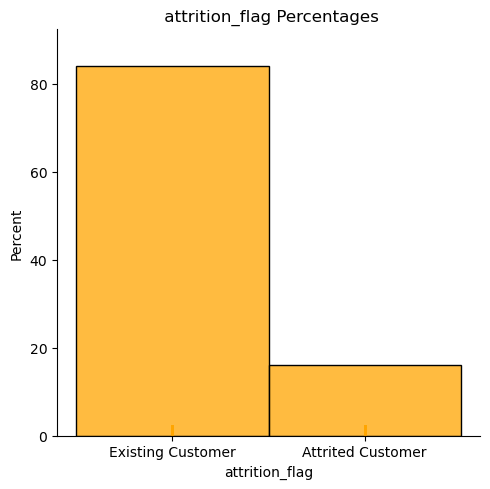

In [60]:
plot_dist_plot(credicard_raw_df, target_variable, '../images/churn_percentage.png')

#### 3.2.2  Distributions per Categorical Type

#####  Let's observe the churn distribution per caterorical type

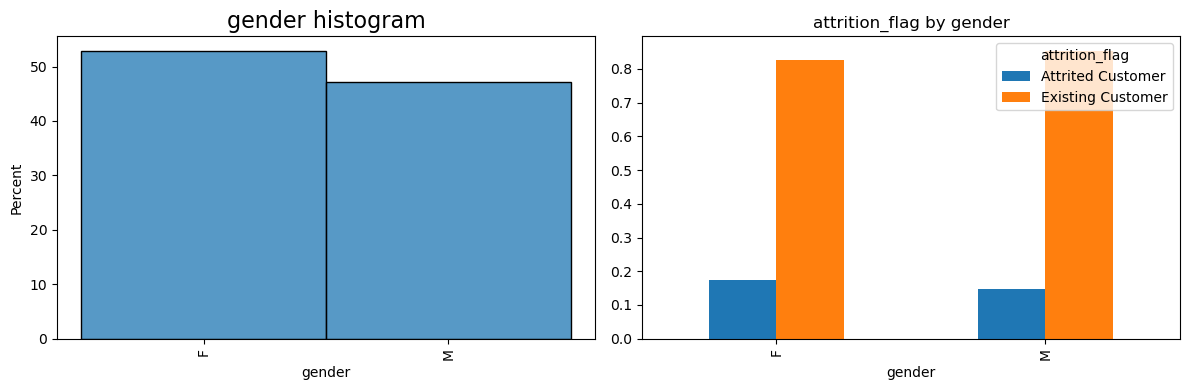

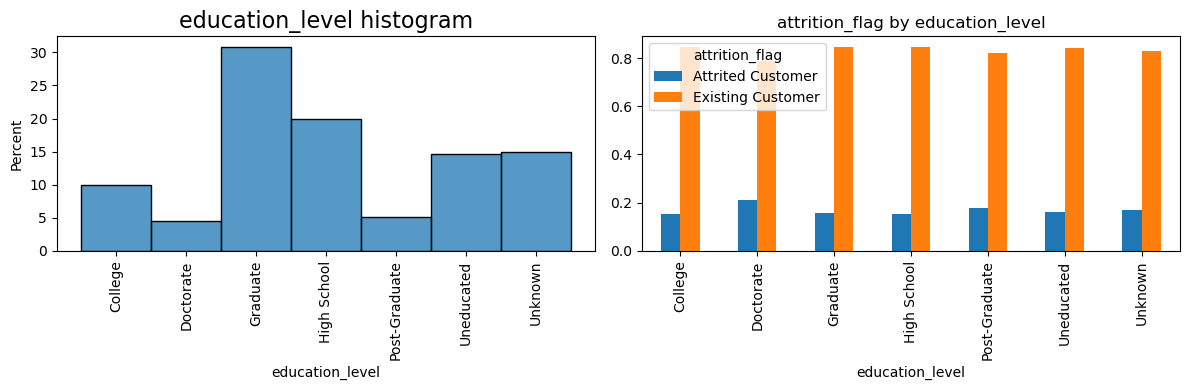

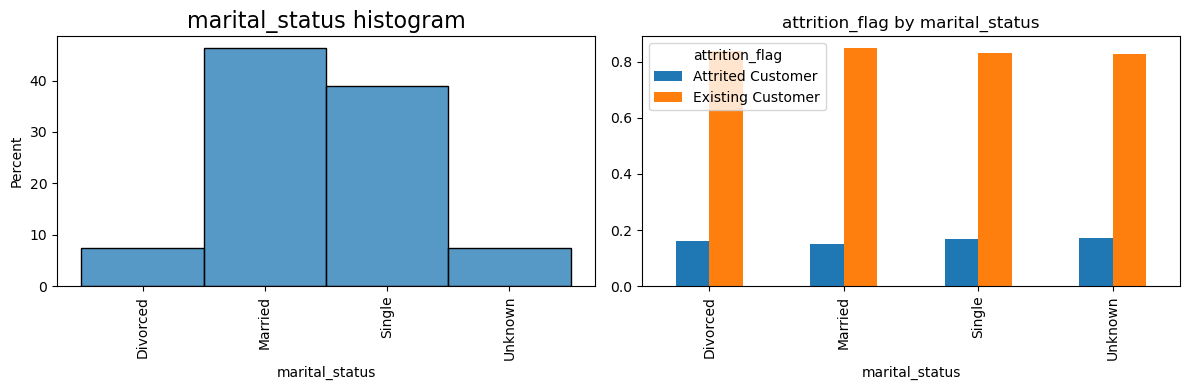

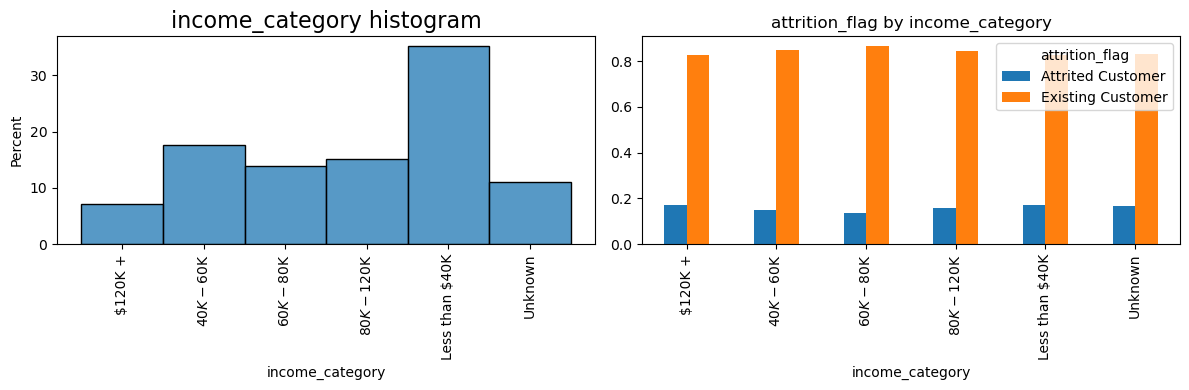

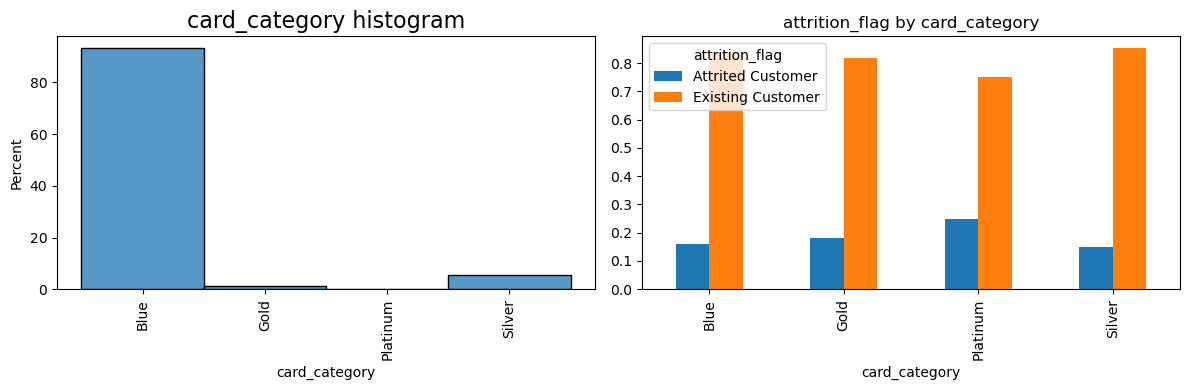

In [64]:
# Let's check how each categorical type feature impacts the churn
for col in categorical_feature_columns:
    plot_categorical_feature_vs_target(credicard_raw_df, col, target_variable, f'../images/churn_by_{col}.png')

#### Categorical Data Observations 
- High Imbalance in input data, since the existing vs. attrited customers ratio is 84:16
- **Gender:** Data is almost equally distributed between Males and Females
  - So Attrition is not depends on customer gender
- **Education Level:**
  - 31% customers are Graduate
  - Attrition also not depends on Education level
- **Marital Status:**
   - ~85% customers are either Single or Married, where 46.7% of the customers are Married
   - At high level attrition also not depends on Marital status
- **Income Level:**
   - Interestingly higher income customers has slightly higher attrition rate
   - 35% customers earn less than $40k and 36% earns $60k or more
- **Card Type:**
    - ~93% customers have Blue card
    - Platinum customers has higher attrition rate followed by gold

#### 3.2.3 Numerical Type Feature Distributions

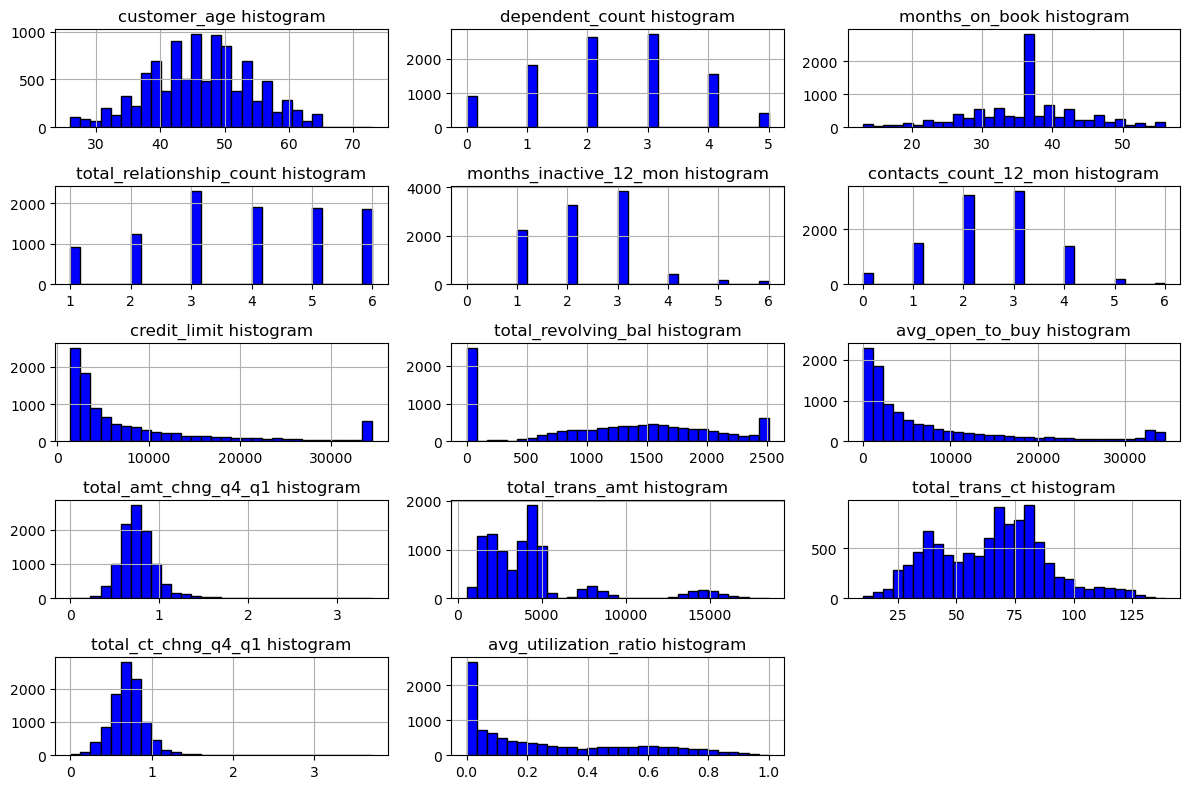

In [68]:
plot_numerical_feature_hist_subplots(credicard_raw_df, numerical_feature_columns, '../images/numerical_feature_type_distributions.png')

<Figure size 1800x600 with 0 Axes>

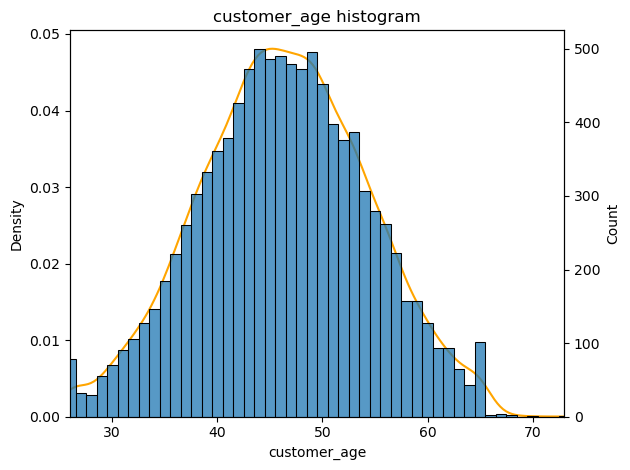

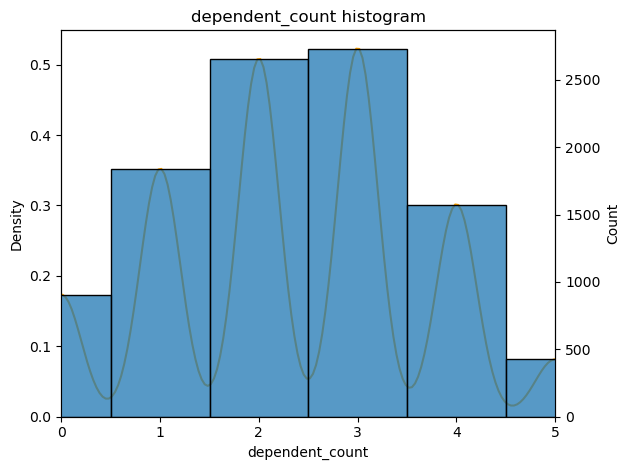

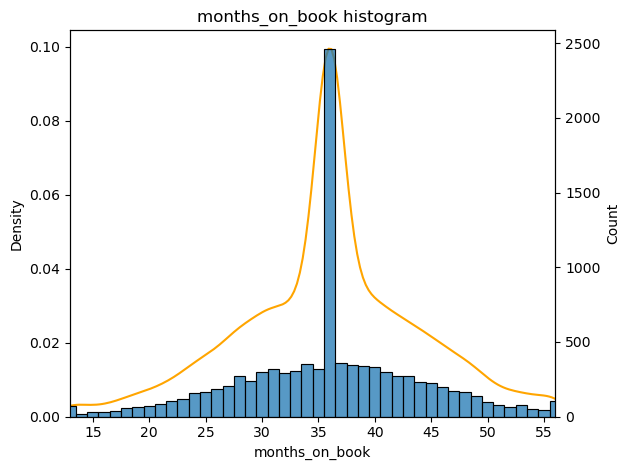

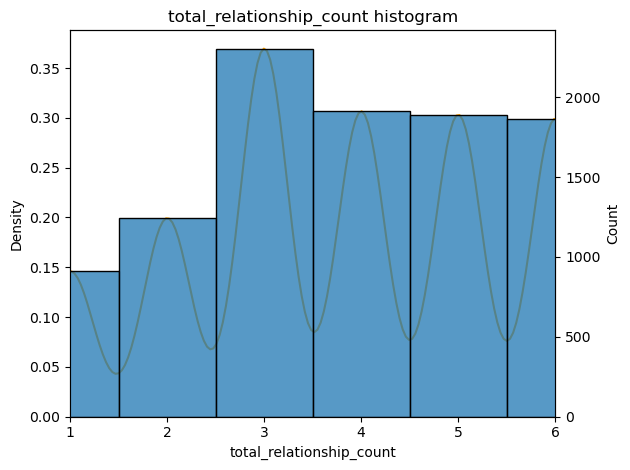

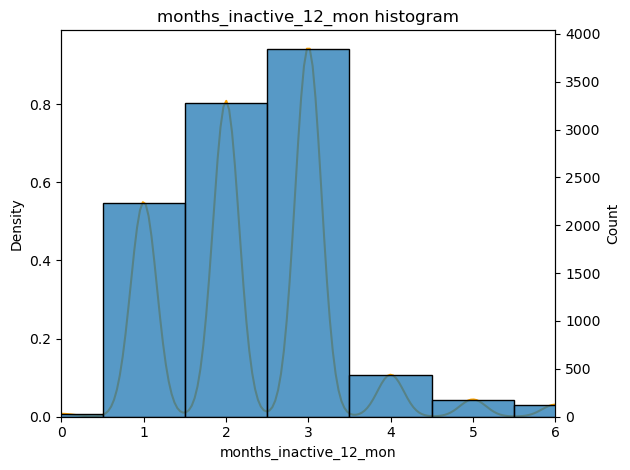

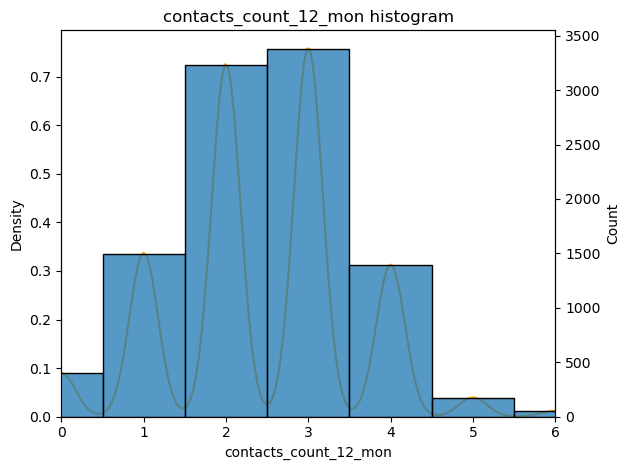

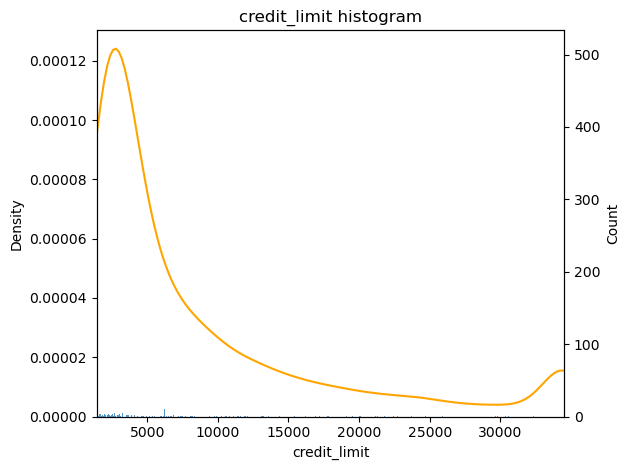

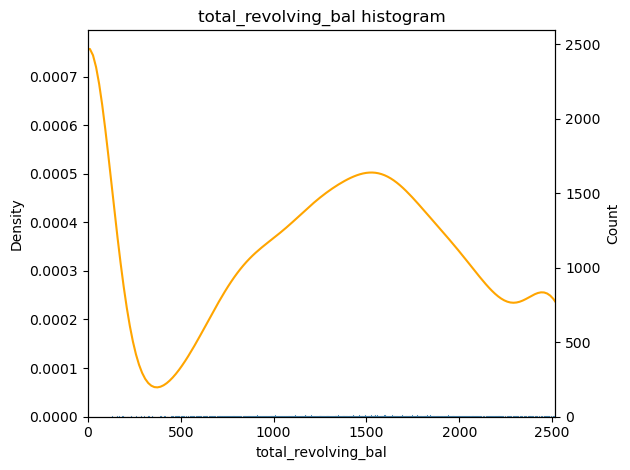

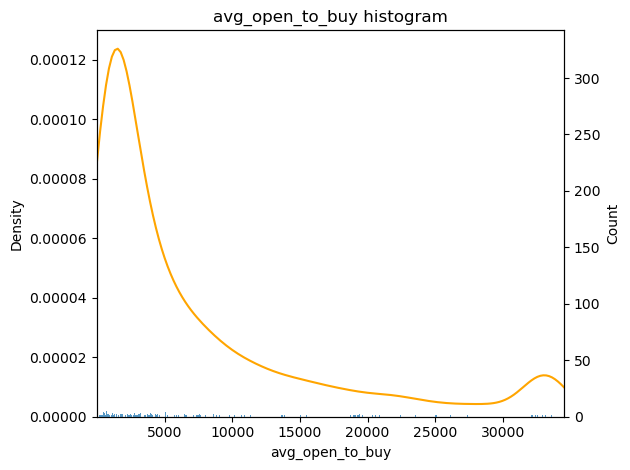

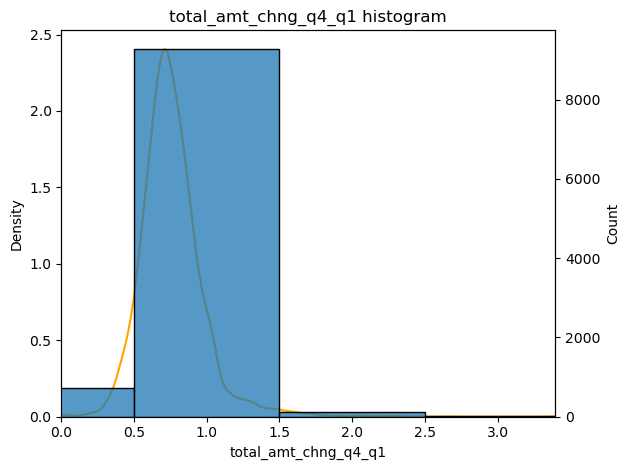

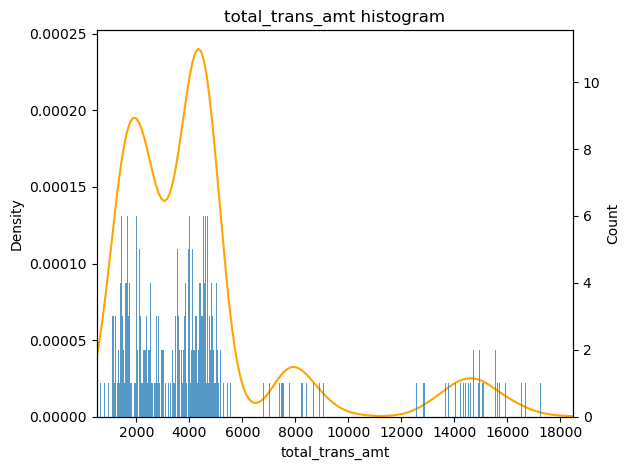

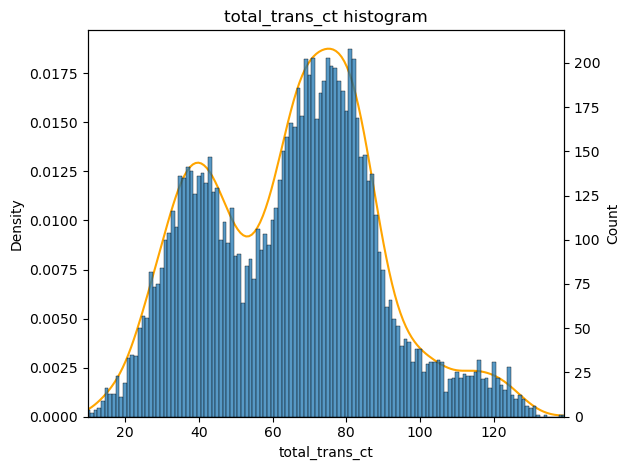

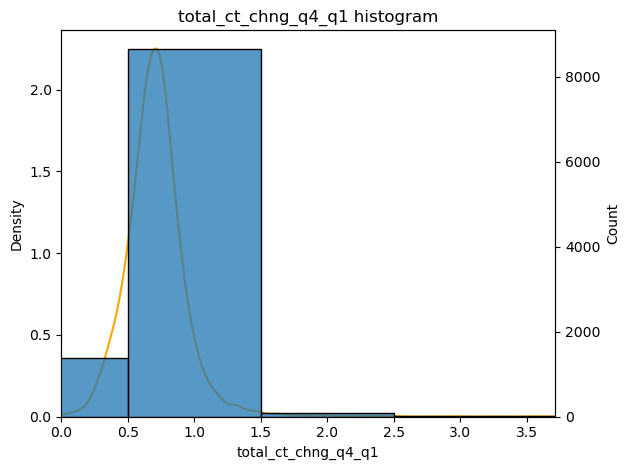

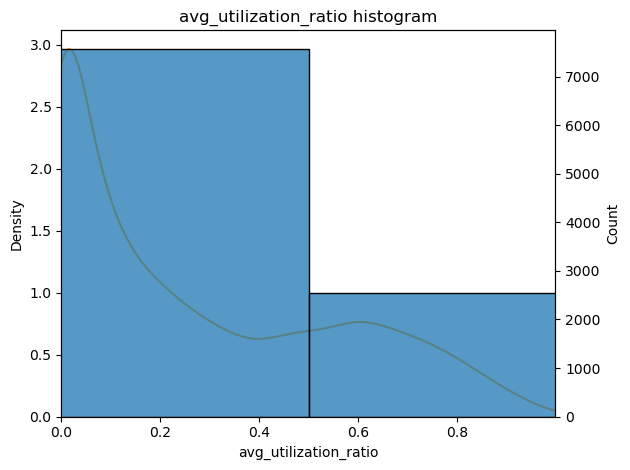

In [70]:
plot_numerical_feature_hist_kde_distributions(credicard_raw_df, numerical_feature_columns, '../images')

##### 3.2.4 Numerical Type Feature vs Target Variable 

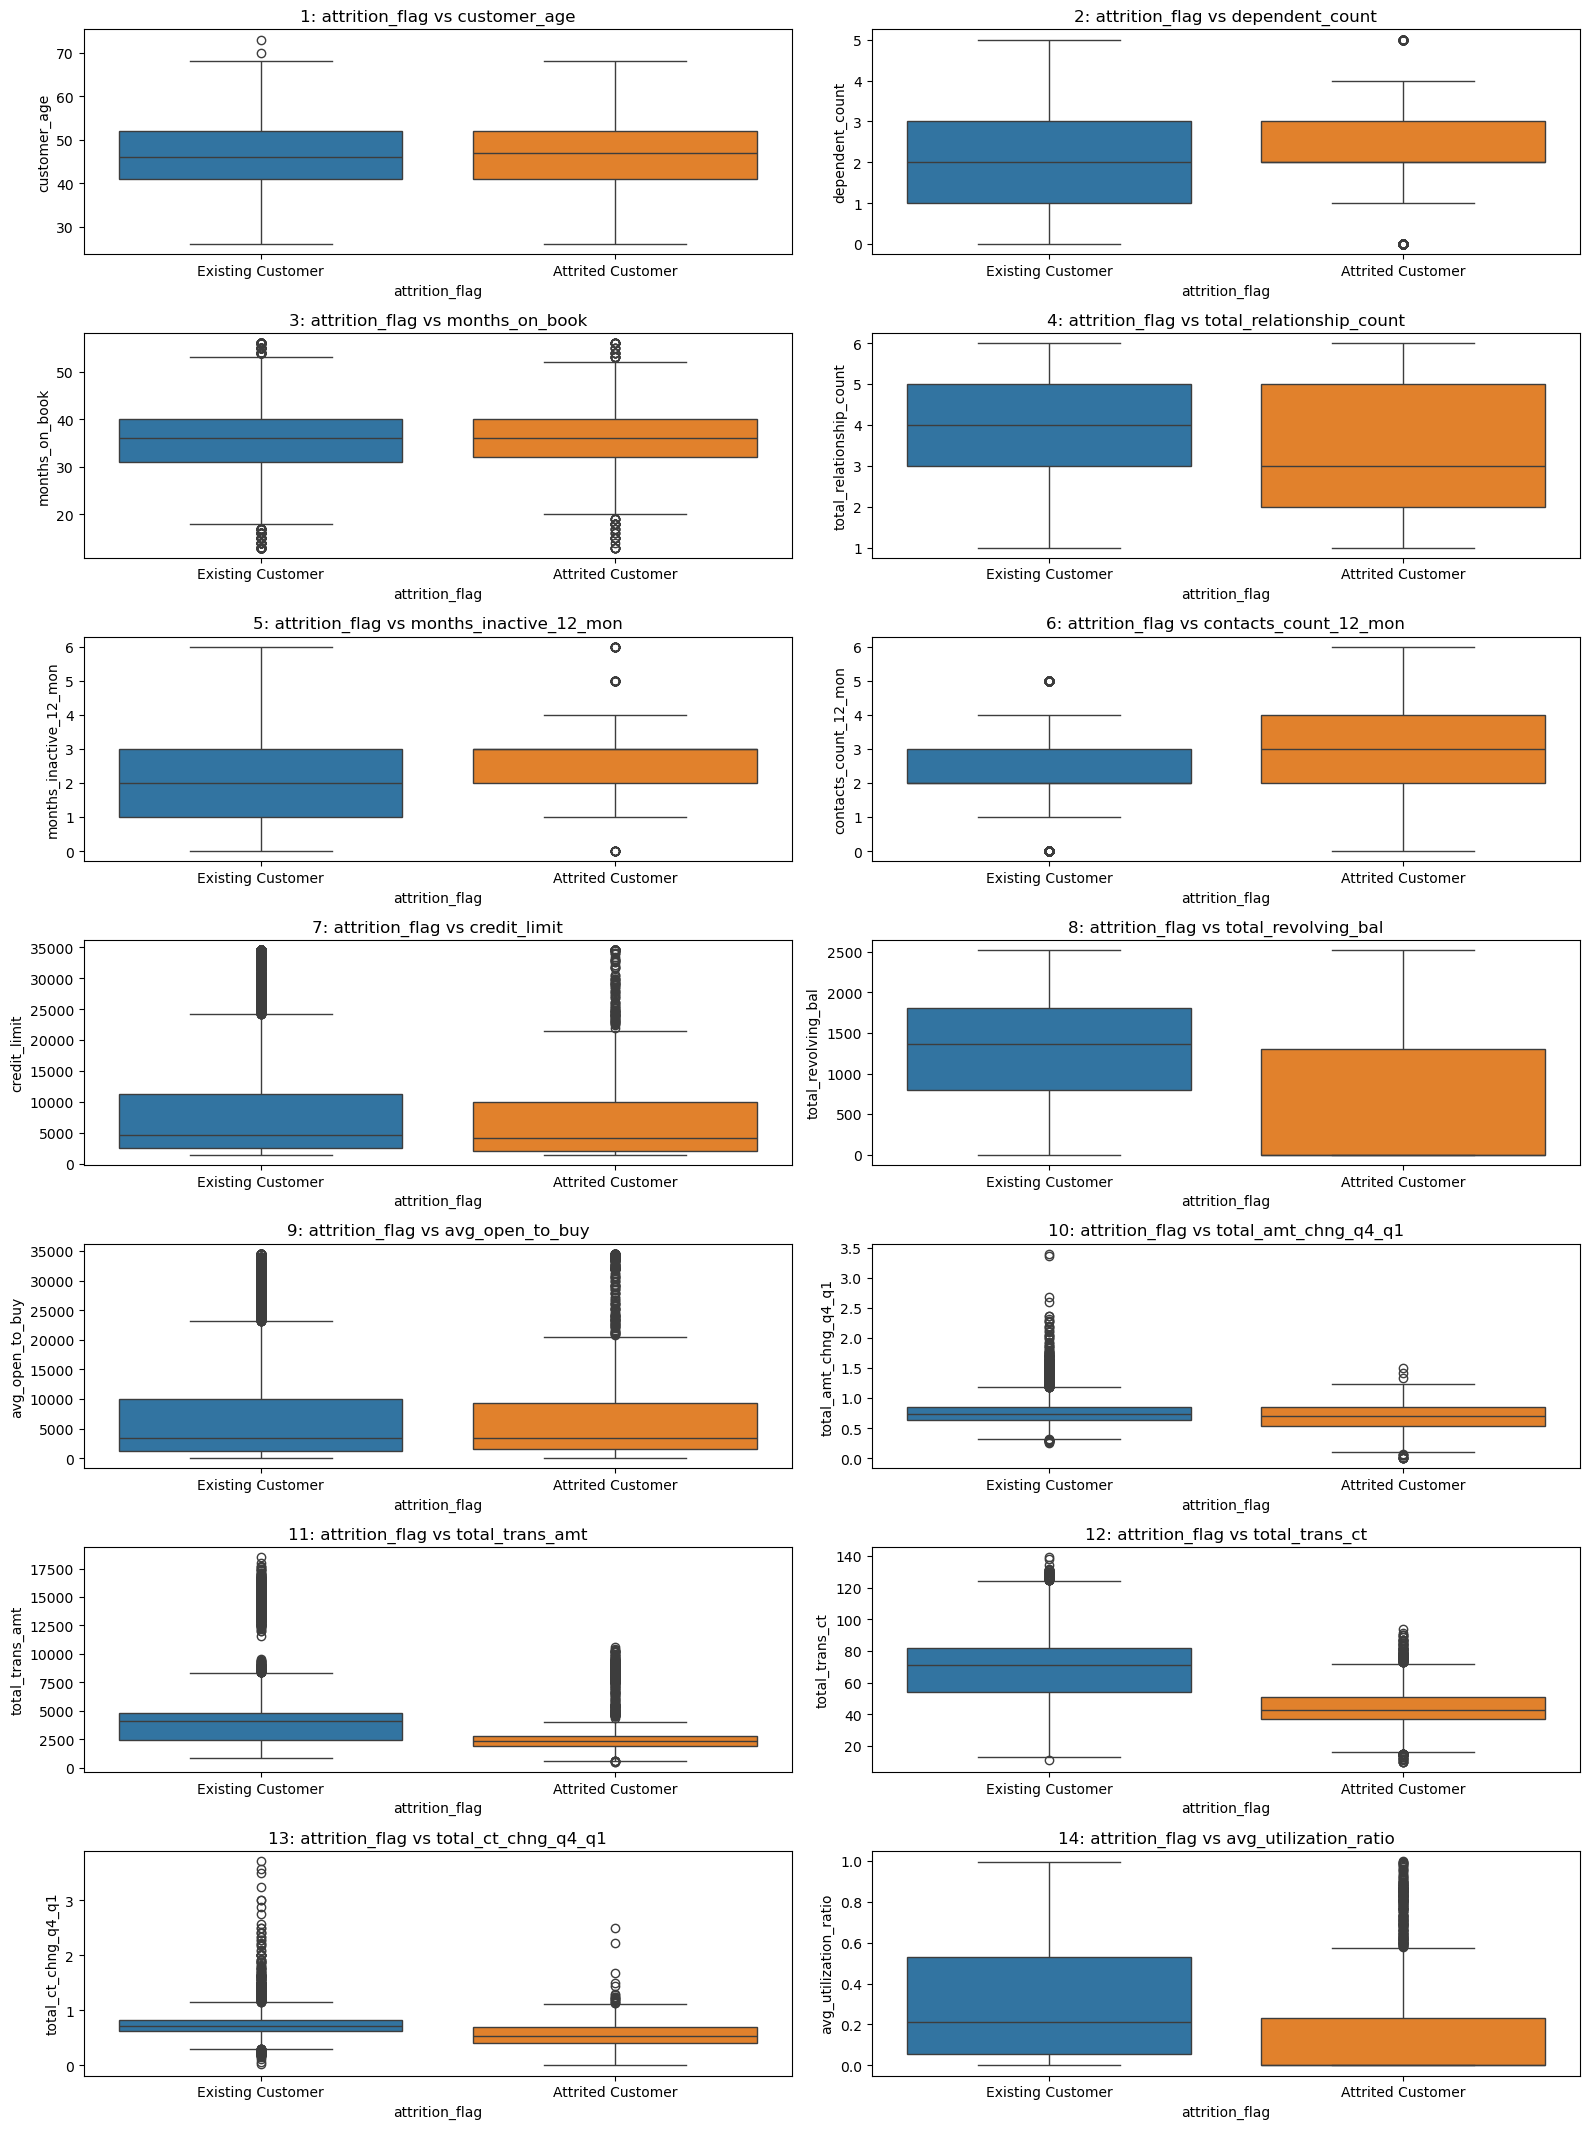

In [72]:
box_plot_numeric_type_vs_target_variable(credicard_raw_df, numerical_feature_columns, target_variable, '../images')

##### 3.2.5 Looking into outliers

##### Analyze customers with higher credit limit

In [75]:
credicard_raw_df[credicard_raw_df['credit_limit'] > 23000]["income_category"].value_counts(normalize=True)

income_category
$80K - $120K     0.421
$120K +          0.302
$60K - $80K      0.156
Unknown          0.110
$40K - $60K      0.012
Less than $40K   0.000
Name: proportion, dtype: float64

In [76]:
credicard_raw_df[credicard_raw_df['credit_limit'] > 23000]["card_category"].value_counts(normalize=True)

card_category
Blue       0.592
Silver     0.310
Gold       0.083
Platinum   0.015
Name: proportion, dtype: float64

### Observations from numerical features

- `customer_age` is normally distributed
- `dependent_count` is mostly 2 to 3
- `months_on_book` most of the customers are 36 months in relation with bank
-  Most of the customers are using more than 3 services of the bank/credit card
-  There are customers inactive for more than 5 months, they might lead to churn
-  median credit limit is 5K, but there are outliers at higher end
  - As we can observe, Most of the higher credit limit customers are salary > 60K
  - And most of these high credit limit customers have either silver or blue card types
-  `total_revolving_bal` is interesting
  - There are users, who doesn't use the credit card as their revolving balance is 0
  - most of the churned customers have less revolving balance
- `Average Open to Buy` has lots of higher end outliers, which means there are customers who uses only very small amount of their credit limit
- `Utilization ratio` is right skewed

####  3.2.5 correlation analysis for numerical features

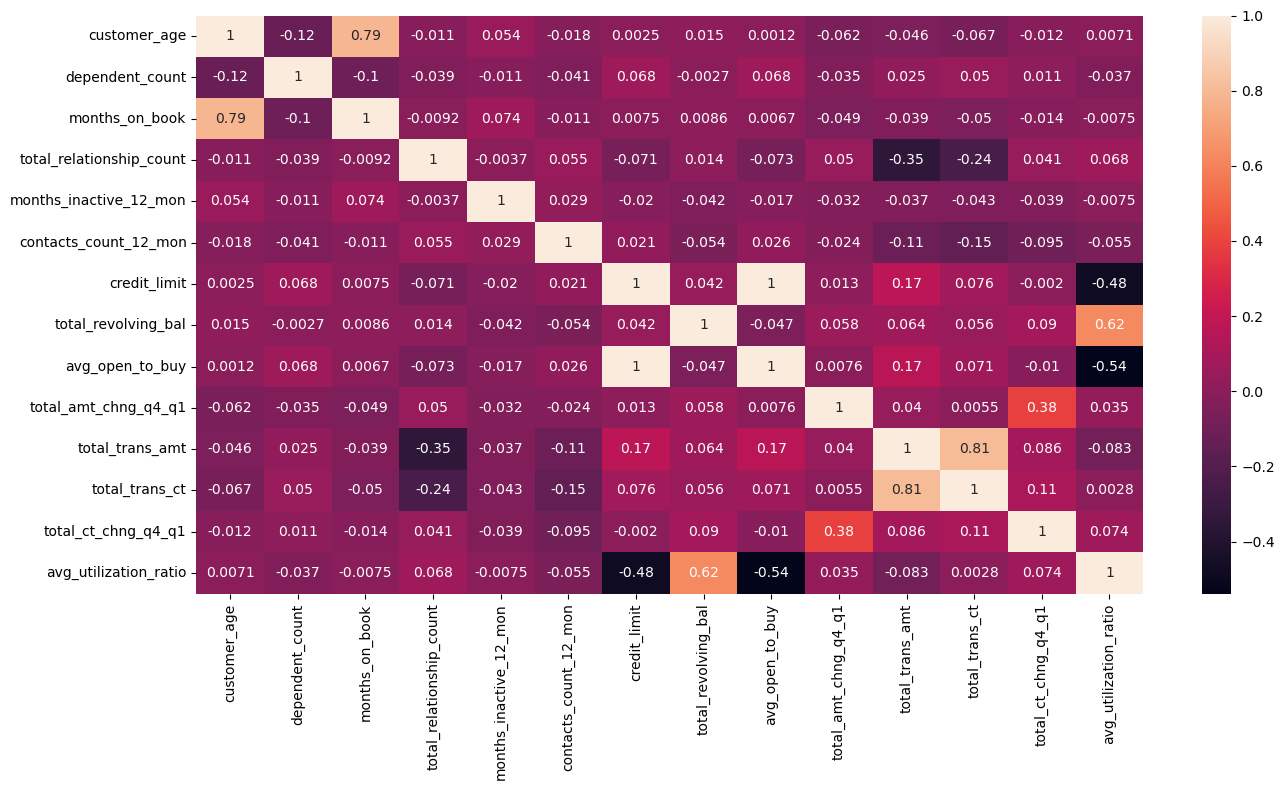

In [79]:
plot_heatmap(credicard_raw_df, numerical_feature_columns, target_variable, '../images/feature_correlations.png')

### EDA Summary

##### Correlation Observations
- Credit card limit and Average Open to Buy have 100% correlation
- Months on book and Customer Age have quite strong correlation
- Average Utilization Ration and Total Revolving Balance are also a bit correlated it appears
- Customer Churn appears to be uncorrelated with Customer Age, Dependent Count, Months on Book, Open to Buy, Credit Limit, we'll remove these from dataset

#### Patterns Of Churned Customers
- Lower `total transaction amount` and `transaction count`
- Lower `resolving balance`
- Lower `transaction count change Q4 to Q1`
- Higher number of times contacted by the bank
